In [ ]:
import abm_utils.familiarity as fam
import h3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
data_exp = pd.read_csv("C:/Users/freud/Tensorflow/DataFrames/all_waybill_info_meituan_0322.csv")

min_lat = 0
min_lon = 0
max_lat = 46000000
max_lon = 174700000

"first we will filter the data and remvoing a order area encupsuled from the main area of operation"

data_exp = data_exp[
        (data_exp['recipient_lat'] >= min_lat) &
        (data_exp['recipient_lat'] <= max_lat) &
        (data_exp['recipient_lng'] >= min_lon) &
        (data_exp['recipient_lng'] <= max_lon) &
        (data_exp['sender_lat'] >= min_lat) &
        (data_exp['sender_lat'] <= max_lat) &
        (data_exp['sender_lng'] >= min_lon) &
        (data_exp['sender_lng'] <= max_lon)] 

data_exp = data_exp[data_exp['is_courier_grabbed'] != 0].reset_index(drop=True) #data cleaning

data_exp['platform_order_date'] = data_exp['platform_order_time']
data_exp['platform_order_date'] = pd.to_datetime(data_exp['platform_order_date'], unit='s') + pd.Timedelta(hours=8) #Offset of 8 hours, because it is probably a chinese timezone
data_exp = data_exp[data_exp['platform_order_date'] >= '2022-10-17']
#data_exp = data_exp[data_exp['estimate_meal_prepare_time'] != 0].reset_index(drop=True) #data cleaning
data_exp = data_exp[data_exp['is_prebook'] != 1].reset_index(drop=True) #data cleaning

"For the H3 library, we need standard decimal degrees"

scaling_factor = 1_000_000
data_exp['sender_lat'] = data_exp['sender_lat'] / scaling_factor
data_exp['sender_lng'] = data_exp['sender_lng'] / scaling_factor
data_exp['recipient_lat'] = data_exp['recipient_lat'] / scaling_factor
data_exp['recipient_lng'] = data_exp['recipient_lng'] / scaling_factor
data_exp["grab_lat"] = data_exp["grab_lat"] / scaling_factor
data_exp["grab_lng"] = data_exp["grab_lng"] / scaling_factor



In [35]:
Res = 13  # All courier positions and specific locations (restaurants, customers) are mapped to this grid.
try:
    data_exp['sender_h3'] = data_exp.apply(
        lambda row: h3.latlng_to_cell(row['sender_lat'], row['sender_lng'], Res),
        axis=1
    )
    data_exp['recipient_h3'] = data_exp.apply(
        lambda row: h3.latlng_to_cell(row['recipient_lat'], row['recipient_lng'], Res),
        axis=1
    )
    data_exp['grab_h3'] = data_exp.apply(
        lambda row: h3.latlng_to_cell(row['grab_lat'], row['grab_lng'], Res),
        axis=1
    )
    print("Conversion to H3 indices complete.")


except h3.H3ValueError as e:
    print("ERROR: A coordinate in the dataset is invalid. H3 message: {e}")

Conversion to H3 indices complete.


In [36]:
# Group by 'courier_id' and count 'order_id' to get total orders
courier_orders = data_exp.groupby('courier_id')['order_id'].count().reset_index()
courier_orders.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Preview
print(courier_orders.head())

   courier_id  total_orders
0           0            16
1           1            16
2           2           147
3           3            84
4           4           257


In [37]:
# --- Task 2: Workdays Analysis & One-Hot Encoding ---

# Convert the timestamp column to datetime objects
data_exp['platform_order_date'] = pd.to_datetime(data_exp['platform_order_date'])

# Extract the name of the day (e.g., 'Monday')
data_exp['day_name'] = data_exp['platform_order_date'].dt.day_name()

# List of days for ordering
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create One-Hot Encoding: A new column for each day (1 if worked, 0 if not)
for day in days_of_week:
    data_exp[day] = (data_exp['day_name'] == day).astype(int)

# 1. Sum up the One-Hot columns per courier (shows frequency per weekday)
days_encoding = data_exp.groupby('courier_id')[days_of_week].sum().reset_index()

# 2. Count distinct/unique dates worked (e.g., worked on 3 different dates total)
data_exp['date_only'] = data_exp['platform_order_date'].dt.date
unique_days = data_exp.groupby('courier_id')['date_only'].nunique().reset_index(name='days_worked_count')

# Merge days info
courier_days_stats = unique_days.merge(days_encoding, on='courier_id')

# Preview
print(courier_days_stats.head())

   courier_id  days_worked_count  Monday  Tuesday  Wednesday  Thursday  \
0           0                  4       2        4          0         7   
1           1                  3       5        0          0         4   
2           2                  8      31       12         17         6   
3           3                  7      35        0         11         5   
4           4                  8      69       30         36        20   

   Friday  Saturday  Sunday  
0       0         0       3  
1       7         0       0  
2      20        39      22  
3       6         9      18  
4      32        36      34  


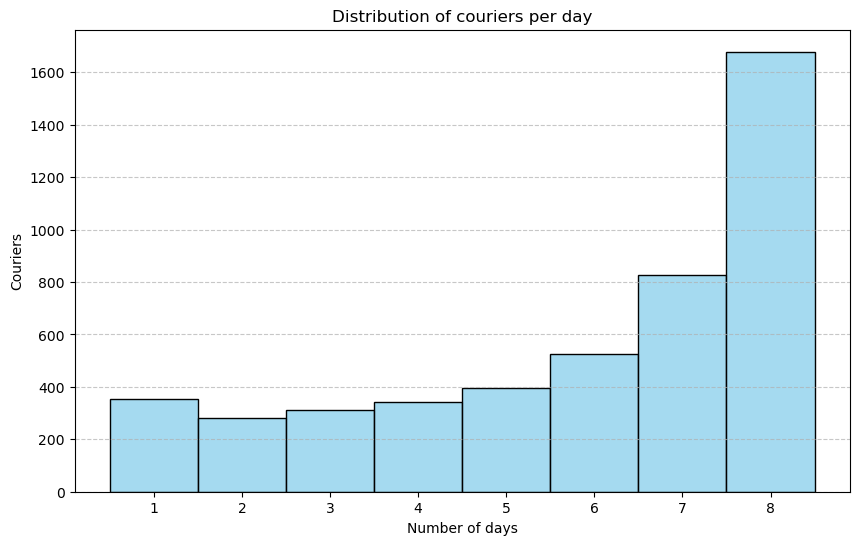

In [38]:

plt.figure(figsize=(10, 6))

sns.histplot(data=unique_days, x='days_worked_count', discrete=True, color='skyblue', edgecolor='black')

plt.title('Distribution of couriers per day')
plt.xlabel('Number of days')
plt.ylabel('Couriers')
plt.xticks(range(1, 9)) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [39]:
# Function to get parent hexagon at resolution 8
def to_res_8(h3_addr):
    try:
        # Converts the H3 index to its parent at resolution 8
        return h3.cell_to_parent(h3_addr, 8)
    except:
        return None

# Apply the conversion to the 'sender_h3' column
data_exp['h3_res8'] = data_exp['sender_h3'].apply(to_res_8)

# Count orders per courier per specific Res 8 area
area_counts = data_exp.groupby(['courier_id', 'h3_res8']).size().reset_index(name='order_count_in_area')

valid_areas = area_counts[area_counts['order_count_in_area'] >= 10]

courier_areas = valid_areas.groupby('courier_id')['h3_res8'].nunique().reset_index(name='valid_areas_count_res8')

print(courier_areas.head())

   courier_id  valid_areas_count_res8
0           2                       3
1           3                       2
2           4                      10
3           5                       7
4           6                       1


In [40]:
# --- Final Merge ---

# Start with order counts
final_df = courier_orders.merge(courier_days_stats, on='courier_id', how='left')

# Merge area counts (use left join, as some couriers might not have areas with >10 orders)
final_df = final_df.merge(courier_areas, on='courier_id', how='left')

# Fill NaN values with 0 for couriers who didn't meet the area threshold
final_df['valid_areas_count_res8'] = final_df['valid_areas_count_res8'].fillna(0).astype(int)

# Show final result
final_df.head(10)

,courier_id,total_orders,days_worked_count,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,valid_areas_count_res8
0,0,16,4,2,4,0,7,0,0,3,0
1,1,16,3,5,0,0,4,7,0,0,0
2,2,147,8,31,12,17,6,20,39,22,3
3,3,84,7,35,0,11,5,6,9,18,2
4,4,257,8,69,30,36,20,32,36,34,10
5,5,196,8,36,35,24,28,27,20,26,7
6,6,125,8,31,19,10,17,17,18,13,1
7,7,111,8,32,15,7,12,8,17,20,3
8,8,27,7,1,6,5,4,4,1,6,1
9,9,118,6,46,19,0,0,17,22,14,4


In [41]:
final_df.sort_values("total_orders")

,courier_id,total_orders,days_worked_count,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,valid_areas_count_res8
4711,4954,1,1,1,0,0,0,0,0,0,0
4682,4907,1,1,0,1,0,0,0,0,0,0
4680,4905,1,1,0,0,1,0,0,0,0,0
4617,4828,1,1,0,0,0,0,0,0,1,0
4267,4450,1,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
967,1033,462,8,114,52,54,56,64,58,64,2
1943,2060,464,8,126,56,63,40,55,53,71,10
135,151,470,8,104,64,56,68,58,60,60,10
284,313,480,8,130,66,29,52,66,59,78,10


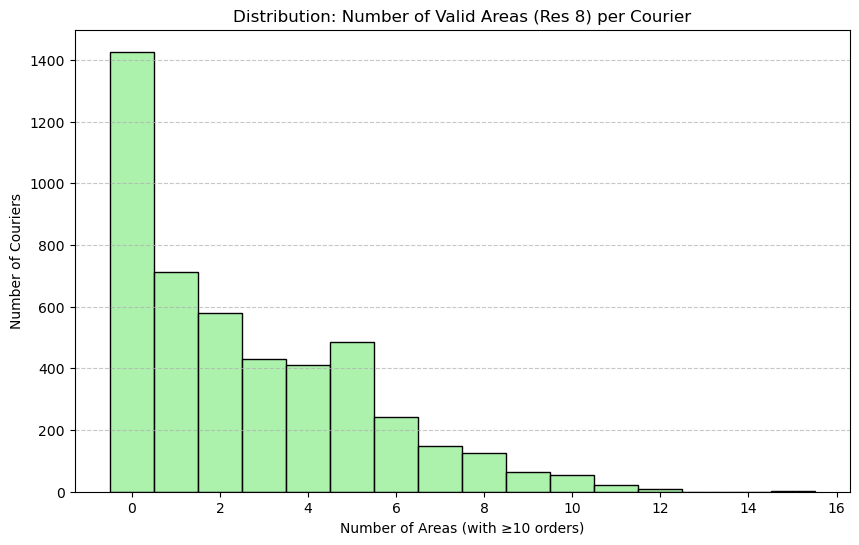

In [42]:
plt.figure(figsize=(10, 6))


sns.histplot(data=final_df, x='valid_areas_count_res8', discrete=True, color='lightgreen', edgecolor='black')

# Labels and Title in English
plt.title('Distribution: Number of Valid Areas (Res 8) per Courier')
plt.xlabel('Number of Areas (with ≥10 orders)')
plt.ylabel('Number of Couriers')

# Optional: Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [43]:
# --- Task 4: Calculate Working Shifts ---

# 1. Sort values to ensure correct chronological order per courier
data_exp = data_exp.sort_values(by=['courier_id', 'grab_time'])

# 2. Calculate the 'gap' between the current order's grab_time and the PREVIOUS order's arrive_time
# We group by courier_id so we don't compare the time of Courier A with Courier B
data_exp['prev_arrive_time'] = data_exp.groupby('courier_id')['arrive_time'].shift(1)

# Calculate gap in seconds
# Handle NaN for the first record of each courier (fill with grab_time to result in 0 gap)
data_exp['gap_seconds'] = data_exp['grab_time'] - data_exp['prev_arrive_time']

# 3. Define the Threshold (1 hour = 3600 seconds)
# A new shift starts if:
# a) It is the first order of the courier (prev_arrive_time is null) OR
# b) The gap is greater than 3600 seconds
threshold = 3600
data_exp['is_new_shift'] = (data_exp['prev_arrive_time'].isna()) | (data_exp['gap_seconds'] > threshold)

# 4. Create a unique 'shift_id'
# cumsum() increments the ID every time 'is_new_shift' is True
data_exp['shift_id'] = data_exp.groupby('courier_id')['is_new_shift'].cumsum()

# 5. Aggregate to find Start and End of each shift
shifts = data_exp.groupby(['courier_id', 'shift_id']).agg(
    shift_start=('grab_time', 'min'),
    shift_end=('arrive_time', 'max'),
    orders_in_shift=('order_id', 'count')
).reset_index()

# Calculate duration in hours
shifts['duration_hours'] = (shifts['shift_end'] - shifts['shift_start']) / 3600

# Convert timestamps to readable dates for display
shifts['start_readable'] = pd.to_datetime(shifts['shift_start'], unit='s')
shifts['end_readable'] = pd.to_datetime(shifts['shift_end'], unit='s')

# Preview the calculated shifts
print(shifts[['courier_id', 'start_readable', 'end_readable', 'duration_hours', 'orders_in_shift']].head(10))

   courier_id      start_readable        end_readable  duration_hours  \
0           0 2022-10-17 13:59:59 2022-10-17 15:33:02        1.550833   
1           0 2022-10-18 14:40:55 2022-10-18 15:55:47        1.247778   
2           0 2022-10-20 14:30:25 2022-10-20 16:06:10        1.595833   
3           0 2022-10-23 14:11:40 2022-10-23 15:02:38        0.849444   
4           1 2022-10-17 03:11:53 2022-10-17 04:07:23        0.925000   
5           1 2022-10-19 16:16:16 2022-10-19 17:15:00        0.978889   
6           1 2022-10-20 16:15:53 2022-10-20 16:40:07        0.403889   
7           1 2022-10-21 03:28:03 2022-10-21 04:35:35        1.125556   
8           2 2022-10-16 16:20:49 2022-10-16 17:34:24        1.226389   
9           2 2022-10-17 01:07:25 2022-10-17 07:44:59        6.626111   

   orders_in_shift  
0                2  
1                4  
2                7  
3                3  
4                5  
5                4  
6                1  
7                6  
8      

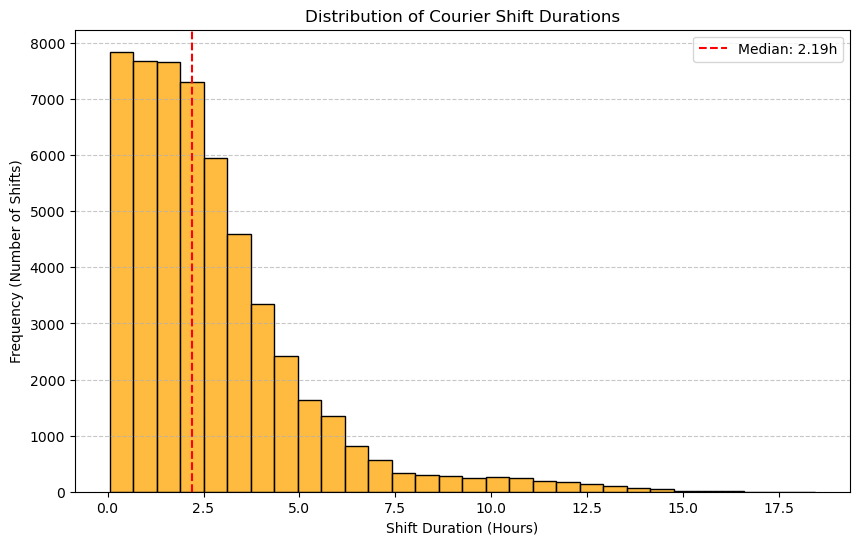

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Plot histogram of shift durations
sns.histplot(data=shifts, x='duration_hours', bins=30, color='orange', edgecolor='black')

plt.title('Distribution of Courier Shift Durations')
plt.xlabel('Shift Duration (Hours)')
plt.ylabel('Frequency (Number of Shifts)')

# Add a vertical line for the median duration
median_duration = shifts['duration_hours'].median()
plt.axvline(median_duration, color='red', linestyle='--', label=f'Median: {median_duration:.2f}h')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [45]:
# Select clean columns to display
schedule_table = shifts[['courier_id', 'start_readable', 'end_readable', 'duration_hours', 'orders_in_shift']]

# Sort by Courier and Start Time
schedule_table = schedule_table.sort_values(['courier_id', 'start_readable'])

# Display the first 15 entries
schedule_table.to_csv('courier_shifts.csv')
schedule_table.head(15)

,courier_id,start_readable,end_readable,duration_hours,orders_in_shift
0,0,2022-10-17 13:59:59,2022-10-17 15:33:02,1.550833,2
1,0,2022-10-18 14:40:55,2022-10-18 15:55:47,1.247778,4
2,0,2022-10-20 14:30:25,2022-10-20 16:06:10,1.595833,7
3,0,2022-10-23 14:11:40,2022-10-23 15:02:38,0.849444,3
4,1,2022-10-17 03:11:53,2022-10-17 04:07:23,0.925000,5
5,1,2022-10-19 16:16:16,2022-10-19 17:15:00,0.978889,4
6,1,2022-10-20 16:15:53,2022-10-20 16:40:07,0.403889,1
7,1,2022-10-21 03:28:03,2022-10-21 04:35:35,1.125556,6
8,2,2022-10-16 16:20:49,2022-10-16 17:34:24,1.226389,5
9,2,2022-10-17 01:07:25,2022-10-17 07:44:59,6.626111,12


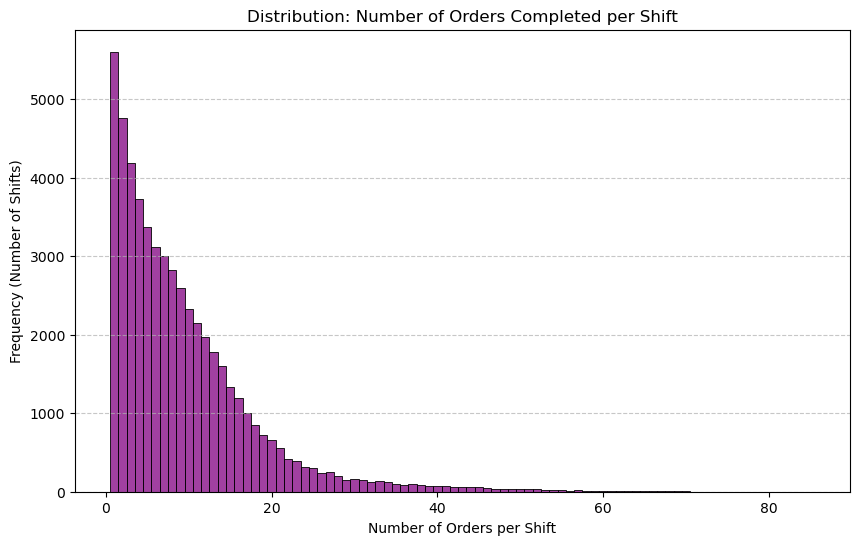

In [46]:
# We use the 'shifts' DataFrame created in Block 9
plt.figure(figsize=(10, 6))

# Create histogram
# discrete=True ensures the bars are centered on whole numbers (1, 2, 3...)
sns.histplot(data=shifts, x='orders_in_shift', discrete=True, color='purple', edgecolor='black')

plt.title('Distribution: Number of Orders Completed per Shift')
plt.xlabel('Number of Orders per Shift')
plt.ylabel('Frequency (Number of Shifts)')

# Add grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()